# Sentiment Analysis on IMDb Reviews

In [1]:
from __future__ import print_function, division

Download and extract the IMDB sentiment dataset:
    
    wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    tar xfz aclImdb_v1.tar.gz

First, we pre-process the dataset, converting each review to a sequence of word index numbers.

In [2]:
# Vocabulary: All words used, starting by the most frequent
with open('aclImdb/imdb.vocab') as f:
    vocab = [word.rstrip() for word in f]
    # Keep only most frequent 5000 words rather than all 90000
    # Just saving memory - the long tail occurs too few times
    # for the model to learn anything anyway
    vocab = vocab[:5000]
    print('%d words in vocabulary' % (len(vocab),))

5000 words in vocabulary


In [3]:
import re

def text_tokens(text):
    text = text.lower()
    text = re.sub("\\s", " ", text)
    text = re.sub("[^a-zA-Z' ]", "", text)
    tokens = text.split(' ')
    return tokens

In [4]:
import os

def load_dataset(dirname):
    X, y = [], []
    # Review files: neg/0_3.txt neg/10000_4.txt neg/10001_4.txt ...
    for y_val, y_label in enumerate(['neg', 'pos']):
        y_dir = os.path.join(dirname, y_label)
        for fname in os.listdir(y_dir):
            fpath = os.path.join(y_dir, fname)
            # print('\r' + fpath + '   ', end='')
            with open(fpath) as f:
                tokens = text_tokens(f.read())
            X.append(tokens)
            y.append(y_val)  # 0 for 'neg', 1 for 'pos'
    print()
    return X, y

In [5]:
X_train, y_train = load_dataset('aclImdb/train/')

# We are cheating here - this is a test set, not a validation set.
# This is just to make results quickly comparable to outside results
# during the tutorial, but you should normally never use the test set
# during training, of course!
X_val, y_val = load_dataset('aclImdb/test/')

In [6]:
len(X_train), len(X_val)

(25000, 25000)

## Bag-of-words Linear Model

In [7]:
def bow_onehot_vector(tokens):
    vector = [0] * len(vocab)
    for t in tokens:
        try:
            vector[vocab.index(t)] = 1
        except:
            pass  # ignore missing words
    return vector

In [11]:
from tqdm import tqdm
X_bow_train = []
X_bow_val = []
for x in tqdm(X_train):
    X_bow_train += [bow_onehot_vector(x)]
for x in tqdm(X_val):
    X_bow_val += [bow_onehot_vector(x)]

100%|██████████| 25000/25000 [01:51<00:00, 223.34it/s]


In [8]:
def best_train_history(history):
    best_epoch = np.argmax(history.history['val_acc'])
    print('Accuracy (epoch %d): %.4f train, %.4f val' % \
          (best_epoch + 1, history.history['acc'][best_epoch], history.history['val_acc'][best_epoch]))
# (Note that sentiment.model is the state after the last epoch rather than best epoch!
# Use ModelCheckpointer to restore the best epoch.)

In [10]:
from keras.layers import Activation, Dense, Input
from keras.models import Model
import numpy as np

class BOWSentimentModel(object):
    def __init__(self):
        bow = Input(shape=(len(vocab),), name='bow_input')
        # weights of all inputs
        sentiment = Dense(1)(bow)
        # normalize to [0, 1] range
        sentiment = Activation('sigmoid')(sentiment)

        self.model = Model(inputs=[bow], outputs=[sentiment])
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def train(self, X, y, X_val, y_val):
        print('Fitting...')
        return self.model.fit(np.array(X), y, validation_data=(np.array(X_val), y_val), epochs=10, verbose=1)

    def predict(self, X):
        return self.model.predict(np.array(X))
    
sentiment = BOWSentimentModel()
history = sentiment.train(X_bow_train, y_train, X_bow_val, y_val)
best_train_history(history)

/Users/aloosley/anaconda2/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bow_input (InputLayer)       (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5001      
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
_________________________________________________________________
Fitting...
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 5s 193us/step - loss: 0.4530 - acc: 0.8339 - val_loss: 0.3632 - val_acc: 0.8710
Epoch 2/10
25000/25000 [==============================] - 3s 137us/step - loss: 0.3144 - acc: 0.8869 - val_loss: 0.3182 - val_acc: 0.8787
Epoch 3/10
25000/25000 [==============================] - 3s 114us/

In [26]:
test_text = 'Good story about a backwoods community in the Ozarks around the turn of the century. Moonshine is the leading industry, fighting and funning the major form of entertainment. One day a stranger enters the community and causes a shake-up among the locals. Beautiful scenery adds much to the story.'
test_text = 'What a great movie, just great!!! psych!.'
test_tokens = text_tokens(test_text)
print(test_text, sentiment.predict([bow_onehot_vector(test_tokens)])[0])

What a great movie, just great!!! psych!. [0.86243796]


In [12]:
import matplotlib.pyplot as plt
def plot_train_history(history):
    plt.figure()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'])
    plt.show()

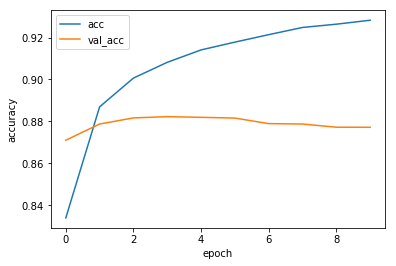

In [13]:
plot_train_history(history)

### Bag-of-Words with Hidden Layer

In [12]:
from keras.layers import Activation, Dense, Input
from keras.models import Model
import numpy as np

class BOWHiddenSentimentModel(object):
    def __init__(self, N=64):
        bow = Input(shape=(len(vocab),), name='bow_input')
        hidden = Dense(N, activation='tanh')(bow)
        sentiment = Dense(1, activation='sigmoid')(hidden)

        self.model = Model(inputs=[bow], outputs=[sentiment])
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def train(self, X, y, X_val, y_val):
        print('Fitting...')
        return self.model.fit(np.array(X), y, validation_data=(np.array(X_val), y_val), epochs=10, verbose=1)

    def predict(self, X):
        return self.model.predict(np.array(X))
    
sentiment = BOWHiddenSentimentModel()
history = sentiment.train(X_bow_train, y_train, X_bow_val, y_val)
best_train_history(history)

/Users/aloosley/anaconda2/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bow_input (InputLayer)       (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                320064    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 320,129
Trainable params: 320,129
Non-trainable params: 0
_________________________________________________________________
Fitting...
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 10s 409us/step - loss: 0.3304 - acc: 0.8587 - val_loss: 0.2987 - val_acc: 0.8728
Epoch 2/10
25000/25000 [==============================] - 8s 337us/step - loss: 0.2357 - acc: 0.9034 - val_loss: 0.3137 - val_acc: 0.8686
Epoch 3/10
25000/25000 [==============================] - 9s 3

NameError: name 'best_train_history' is not defined

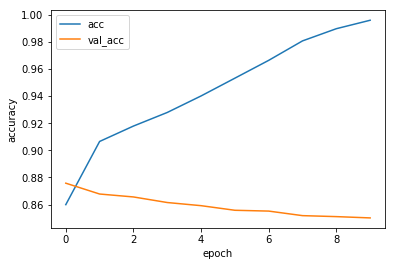

In [15]:
plot_train_history(history)

Overfitting!  Ideas:
  * Apply dropout
  * L2-regularize the weights of the hidden layer
  * Different N values?
  * Multiple hidden layers, with different activation?
  * tf-idf !
  
Can anyone fix the bag-of-words model?

In [32]:
from keras.layers import Activation, Dense, Dropout, Input
from keras.models import Model
from keras import regularizers
import numpy as np

class BOWHiddenRegularizedSentimentModel(object):
    def __init__(self, N=128):
        bow = Input(shape=(len(vocab),), name='bow_input')
        hidden = Dropout(0.5)(Dense(N, activation='relu', kernel_regularizer=regularizers.l2(1e-3))(bow))
        sentiment = Dense(1, activation='sigmoid')(hidden)

        self.model = Model(inputs=[bow], outputs=[sentiment])
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def train(self, X, y, X_val, y_val):
        print('Fitting...')
        return self.model.fit(np.array(X), y, validation_data=(np.array(X_val), y_val), epochs=10, verbose=1)

    def predict(self, X):
        return self.model.predict(np.array(X))
    
sentiment = BOWHiddenRegularizedSentimentModel()
history = sentiment.train(X_bow_train, y_train, X_bow_val, y_val)
best_train_history(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bow_input (InputLayer)       (None, 5000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               640128    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 640,257
Trainable params: 640,257
Non-trainable params: 0
_________________________________________________________________
Fitting...
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 18s 717us/step - loss: 0.4867 - acc: 0.8465 - val_loss: 0.4468 - val_acc: 0.8713
Epoch 2/10
12288/25000 [=============>................] - ETA: 8s - 

KeyboardInterrupt: 

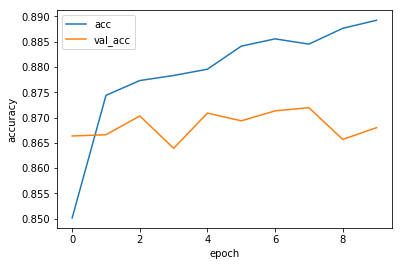

In [31]:
plot_train_history(history)

## GloVe-based Model (let's start with averaging)

Download and extract the official pre-trained GloVe matrix:

    https://nlp.stanford.edu/data/glove.6B.zip
    unzip glove.6B.zip
    
We decided to use GloVe over word2vec as in our experience, GloVe carries word semantics better and works better in semantic-sensitive tasks.  But the difference is not huge.

### Loading GloVe vocabulary

You may need to restart your kernel here if you don't have a lot of free memory, to get rid of the bag-of-words vectors from before.

In [8]:
# Embedding dimension means how many elements each word vector has.
# Common values are 50 and 300.  Generally, larger vectors have more
# capacity to carry information (meaning).  But the training process
# is slower, both vectors and further layers take more memory, and
# there could be higher risk of overfitting.
EMBEDDING_DIM = 50

In [10]:
from tqdm import tqdm
import numpy as np
# let's create a dictionary of each word in the pre-trained GloVe embeddings, saving its location indexes 
import os
GLOVE_DIR = "glove.6B"
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.%dd.txt' % EMBEDDING_DIM)) as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:07, 55364.37it/s]

Found 400000 word vectors.


In [ ]:
# a matrix that is indexed by our vocabulary, containing
# GloVe embedding for each vocabulary element
embedding_matrix = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
for i, word in tqdm(enumerate(vocab)):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        # also, [0] is reserved for padding
        embedding_matrix[i + 1] = embedding_vector

Checking how many words have no pre-trained GloVe word embeddings:

In [ ]:
1. * np.count_nonzero(np.all(embedding_matrix == 0, axis=1)) / len(vocab)  # OOV portion

We are representing reviews as sequences now.  However, each sequence must have the same length on the input in Keras.  We will pad shorter sequences by zeroes from right, but what should be the maximum sequence length?  Let's find a compromise.

In [38]:
lengths = sorted([len(X) for X in X_train])
percentile = 0.90
seq_cutoff = lengths[int(len(lengths)*percentile)]
print('Longest: %d, Average: %f, Median: %d, %d%% percentile: %d tokens' % (lengths[-1], np.mean(lengths), lengths[int(len(lengths)*0.5)], percentile*100, seq_cutoff))

Longest: 2470, Average: 233.807120, Median: 174, 90% percentile: 458 tokens


In [39]:
def vocab_indices_vector(tokens):
    vector = [0] * seq_cutoff
    if len(tokens) > seq_cutoff:
        # Remove the middle
        tokens = tokens[: seq_cutoff // 2] + ['SINGLE_PADDING_IN_THE_MIDDLE'] + tokens[-seq_cutoff // 2 :]
    for i, t in enumerate(tokens):
        try:
            vector[i] = vocab.index(t) + 1  # reserving 0 for padding
        except:
            pass  # ignore missing words
    return vector

In [40]:
X_indices_train = [vocab_indices_vector(x) for x in X_train]
X_indices_val = [vocab_indices_vector(x) for x in X_val]

### GloVe averaging model

In [41]:
from keras.layers import Activation, GlobalAveragePooling1D, Dense, Embedding, Input
from keras.models import Model
import numpy as np

class GloveAvgSentimentModel(object):
    def __init__(self):
        self.model = self.create()
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
    def create(self):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input')                    
        seq_embedded = Embedding(input_dim=len(vocab) + 1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                                 input_length=seq_cutoff, trainable=False)(seq_indices)
        avg_embedded = GlobalAveragePooling1D()(seq_embedded)
        sentiment = Dense(1, activation='sigmoid')(avg_embedded)

        return Model(inputs=[seq_indices], outputs=[sentiment])

    def train(self, X, y, X_val, y_val):
        print('Fitting...')
        return self.model.fit(np.array(X, dtype='int32'), y,
                              validation_data=(np.array(X_val, dtype='int32'), y_val), epochs=10, verbose=1)

    def predict(self, X):
        return self.model.predict(np.array(X))
    
sentiment = GloveAvgSentimentModel()
history = sentiment.train(X_indices_train, y_train, X_indices_val, y_val)
best_train_history(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_input (InputLayer)       (None, 458)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 458, 50)           250050    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 250,101
Trainable params: 51
Non-trainable params: 250,050
_________________________________________________________________
Fitting...
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 4s 180us/step - loss: 0.6839 - acc: 0.5977 - val_loss: 0.6756 - val_acc: 0.6404
Epoch 2/10
25000/25000 [==============================] - 4s 152us/s

Questions:
  * Predict sentiment from mean embedding, or mean sentiment from each embedding?
  * Projection to a latent "sentiment predictive" vector space first?
  
Other ideas (for pretty much all further models):
  * Trainable embeddings?
  * ...what about embeddings from scratch, by the way?
  * Just more epochs?

Advanced idea:
  * Could we visualize importance of individual words towards the predicted sentiment?

### Maximum in a "sentiment predictive" space

In [25]:
from keras.layers import Activation, GlobalMaxPooling1D, Dense, Embedding, Input
from keras.models import Model
import numpy as np

class GloveHiddenMaxSentimentModel(object):
    def __init__(self, N=64):
        self.model = self.create(N)
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
    def create(self, N):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input')                    
        seq_embedded = Embedding(input_dim=len(vocab) + 1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                                 input_length=seq_cutoff, trainable=False)(seq_indices)
        seq_hidden = Dense(N, activation='tanh')(seq_embedded)
        max_hidden = GlobalMaxPooling1D()(seq_hidden)
        sentiment = Dense(1, activation='sigmoid')(max_hidden)

        return Model(inputs=[seq_indices], outputs=[sentiment])

    def train(self, X, y, X_val, y_val):
        print('Fitting...')
        return self.model.fit(np.array(X, dtype='int32'), y,
                              validation_data=(np.array(X_val, dtype='int32'), y_val), epochs=10, verbose=1)

    def predict(self, X):
        return self.model.predict(np.array(X))
    
sentiment = GloveHiddenMaxSentimentModel()
history = sentiment.train(X_indices_train, y_train, X_indices_val, y_val)
best_train_history(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_input (InputLayer)       (None, 458)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 458, 50)           250050    
_________________________________________________________________
dense_7 (Dense)              (None, 458, 64)           3264      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 253,379
Trainable params: 3,329
Non-trainable params: 250,050
_________________________________________________________________
Fitting...
['seq_input']
['dense_8']
['seq_input']
['dense_8']
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25

Ideas:
  * Averaging rather than maximum?
  * Do other N values make a difference?

## Convolutions on sequences of embeddings

In [26]:
from keras.layers import Activation, Conv1D, Dense, Embedding, GlobalMaxPooling1D, Input
from keras.models import Model
import numpy as np

class GloveCNNSentimentModel(object):
    def __init__(self, N=64, size=3):
        self.model = self.create(N, size)
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
    def create(self, N, size):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input') 
        seq_embedded = Embedding(input_dim=len(vocab) + 1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                                 input_length=seq_cutoff, trainable=False)(seq_indices)
        seq_conv = Conv1D(N, size, activation='tanh')(seq_embedded)
        max_conv = GlobalMaxPooling1D()(seq_conv)
        hidden_repr = Dense(N, activation='tanh')(max_conv)
        sentiment = Dense(1, activation='sigmoid')(hidden_repr)

        return Model(inputs=[seq_indices], outputs=[sentiment])

    def train(self, X, y, X_val, y_val):
        print('Fitting...')
        return self.model.fit(np.array(X, dtype='int32'), y,
                              validation_data=(np.array(X_val, dtype='int32'), y_val), epochs=10, verbose=1)

    def predict(self, X):
        return self.model.predict(np.array(X))
    
sentiment = GloveCNNSentimentModel()
history = sentiment.train(X_indices_train, y_train, X_indices_val, y_val)
best_train_history(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_input (InputLayer)       (None, 458)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 458, 50)           250050    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 456, 64)           9664      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 263,939
Trainable params: 13,889
Non-trainable params: 250,050
_________________________________________________________________

This model still sucks.  What problems does it have?

But the model below is awesome.  (Stolen from Keras' `examples/imdb_cnn.py`.)
  * What are the differences to the model above?
  * What exactly makes it so awesome?
  * Did we beat the bag-of-words baseline yet?

In [27]:
from keras.layers import Activation, Conv1D, Dense, Embedding, GlobalMaxPooling1D, Input
from keras.models import Model
import numpy as np

class GloveCNNAwesomeSentimentModel(object):
    def __init__(self, N=256, size=3):
        self.model = self.create(N, size)
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
    def create(self, N, size):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input') 
        seq_embedded = Embedding(input_dim=len(vocab) + 1, output_dim=EMBEDDING_DIM,
                                 input_length=seq_cutoff)(seq_indices)
        seq_conv = Conv1D(N, size, activation='relu')(Dropout(0.2)(seq_embedded))
        max_conv = GlobalMaxPooling1D()(seq_conv)
        hidden_repr = Dense(N, activation='relu')(max_conv)
        sentiment = Dense(1, activation='sigmoid')(Dropout(0.2)(hidden_repr))

        return Model(inputs=[seq_indices], outputs=[sentiment])

    def train(self, X, y, X_val, y_val):
        print('Fitting...')
        return self.model.fit(np.array(X, dtype='int32'), y,
                              validation_data=(np.array(X_val, dtype='int32'), y_val), epochs=10, verbose=1)

    def predict(self, X):
        return self.model.predict(np.array(X))
    
sentiment = GloveCNNAwesomeSentimentModel()
history = sentiment.train(X_indices_train, y_train, X_indices_val, y_val)
best_train_history(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_input (InputLayer)       (None, 458)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 458, 50)           250050    
_________________________________________________________________
dropout_2 (Dropout)          (None, 458, 50)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 456, 256)          38656     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
__________

Can we make the model more awesome yet?

Ideas:
  * So what about the Glove pretrained embeddings?
  * Project the embeddings to a more convolution-friendly space?
  * Average pooling instead of max?
  * Is 300D embedding better?
  
Advanced ideas:
  * What about _both_ average and max pooling?
  * `relu` activation is popular in computer vision CNNs instead of `tanh`.
  * Some people recommend `rmsprop` optimizer rather than `adam` for CNNs. Does it matter?

## Recurrence on sequences of embeddings

In [9]:
from keras.layers import Activation, Dense, Embedding, GRU, Input
from keras.models import Model
import numpy as np

class GloveGRUSentimentModel(object):
    def __init__(self, N=64):
        self.model = self.create(N)
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
    def create(self, N):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input') 
        seq_embedded = Embedding(input_dim=len(vocab) + 1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                                 input_length=seq_cutoff, trainable=False)(seq_indices)
        recursive_repr = GRU(N)(seq_embedded)
        sentiment = Dense(1, activation='sigmoid')(recursive_repr)

        return Model(inputs=[seq_indices], outputs=[sentiment])

    def train(self, X, y, X_val, y_val):
        print('Fitting...')
        return self.model.fit(np.array(X, dtype='int32'), y,
                              validation_data=(np.array(X_val, dtype='int32'), y_val), epochs=10, verbose=1)

    def predict(self, X):
        return self.model.predict(np.array(X))
    
sentiment = GloveGRUSentimentModel()
history = sentiment.train(X_indices_train, y_train, X_indices_val, y_val)
best_train_history(history)

/Users/aloosley/anaconda2/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


NameError: name 'seq_cutoff' is not defined

If you take the time to train the model, it seems to really suck after the first epoch.  What could be the problem?  (Imagine the input, and how the RNN processes it.)

The model below fixes the problem - how?  What is the most essential change?

In [ ]:
from keras.layers import Activation, Bidirectional, Dense, Embedding, GRU, Input
from keras.models import Model
import numpy as np

class GloveGRUSentimentModel(object):
    def __init__(self, N=64):
        self.model = self.create(N)
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
    def create(self, N):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input') 
        seq_embedded = Embedding(input_dim=len(vocab) + 1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                                 input_length=seq_cutoff, mask_zero=True)(seq_indices)
        recursive_repr = Bidirectional(GRU(N))(seq_embedded)
        sentiment = Dense(1, activation='sigmoid')(recursive_repr)

        return Model(inputs=[seq_indices], outputs=[sentiment])

    def train(self, X, y, X_val, y_val):
        print('Fitting...')
        return self.model.fit(np.array(X, dtype='int32'), y,
                              validation_data=(np.array(X_val, dtype='int32'), y_val), epochs=10, verbose=1,
                             batch_size=128)

    def predict(self, X):
        return self.model.predict(np.array(X))
    
sentiment = GloveGRUSentimentModel()
history = sentiment.train(X_indices_train, y_train, X_indices_val, y_val)
best_train_history(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_input (InputLayer)       (None, 458)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 458, 50)           250050    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               44160     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 294,339
Trainable params: 294,339
Non-trainable params: 0
_________________________________________________________________
Fitting...
['seq_input']
['dense_14']
['seq_input']
['dense_14']
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 306s 12ms/step - loss: 0.5319 - acc: 0.7134 - val_loss: 0.3534 - val_acc: 0.8473
Epoch 2/10
250

We are overfitting.  Can we improve generalization?

Ideas:
  * `GRU(N, return_sequence=True)` would return a single output element for each input element, rather than a single output for the whole sequence.  What cool things could we use this for?
  * Any ideas to borrow from CNNs?
  * Could we stack multiple GRUs on top of each other?

## Combining CNN and GRU

Let's go wild and take a look at an even more advanced model combining several ideas.  Can you explain what's going on here? Is this madness worth it? Which further improvements might be most desirable to test?

In [ ]:
from keras.layers import Activation, Bidirectional, Conv1D, Dense, Embedding, GlobalMaxPooling1D, GRU, Input, add
from keras.models import Model
import numpy as np

class GloveCNNGRUSISentimentModel(object):
    def __init__(self, N=64, size=3):
        self.model = self.create(N, size)
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', loss_weights=[0.2, 1.0], metrics=['accuracy'])
        
    def create(self, N, size):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input') 
        seq_embedded = Embedding(input_dim=len(vocab) + 1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                                 input_length=seq_cutoff)(seq_indices)
        seq_hidden = Dense(N, activation='tanh')(Dropout(0.2)(seq_embedded))
        
        seq_conv = Conv1D(N, size, activation='tanh', padding='same')(Dropout(0.2)(seq_hidden))
        # Residual skip-connection: The convolution just fine-tunes per-word Dense projection.
        seq_hidden = add([seq_hidden, seq_conv])
        
        recursive_repr = Bidirectional(GRU(N))(seq_hidden)
        sentiment = Dense(1, activation='sigmoid', name='sentiment')(recursive_repr)
        
        # Inception: Also try to make even the hidden representation good enough to predict sentiment.
        max_hidden = GlobalMaxPooling1D()(seq_hidden)
        sentiment_by_hidden = Dense(1, activation='sigmoid', name='sentiment_by_hidden')(max_hidden)

        return Model(inputs=[seq_indices], outputs=[sentiment_by_hidden, sentiment])

    def train(self, X, y, X_val, y_val):
        print('Fitting...')
        return self.model.fit(np.array(X, dtype='int32'), [np.array(y), np.array(y)],
                              validation_data=(np.array(X_val, dtype='int32'),
                                               [np.array(y_val), np.array(y_val)]),
                              epochs=10, verbose=1)

    def predict(self, X):
        return self.model.predict(np.array(X))[-1:]
    
sentiment = GloveCNNGRUSISentimentModel()
history = sentiment.train(X_indices_train, y_train, X_indices_val, y_val)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          (None, 458)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 458, 50)      250050      seq_input[0][0]                  
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 458, 50)      0           embedding_7[0][0]                
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 458, 64)      3264        dropout_4[0][0]                  
__________________________________________________________________________________________________
dropout_5 

Can we do even better? Yes - let's look at the literature.

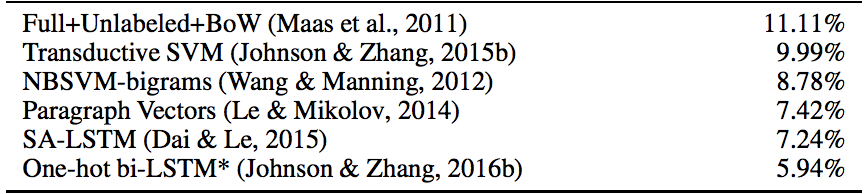

...and https://arxiv.org/pdf/1605.07725.pdf (source of table above; 5.91%)

Final challenge: What common idea is shared by all of the best models? Can you implement one of them based on what you learned today?